# Restaurant Analysis

This data comes from a restaurant in Lemon Grove (near San Diego) over the course of 6 years. General trends and specific holiday effects are already relatively understood by the business owners such as dips in September due to the beginning of school. However, this analysis is important for confirming some suspicions and, more importantly, quantifying their effects.



## Index

[Goals](#Goals)  
[Dataset](#Dataset)  
[Cleaning](#Cleaning)  
[Semi-stationary Analysis](#Semi)  
[Time Series Analysis with Prophet](#Prophet)


## Goals

1. Do a time series analysis to find out seasonality trends in the data
2. How well can I predict sales?
3. Find which holidays/sporting events/important dates we could be missing out on (yearly) by noting outliers or trends.
4. How does credit vs cash sales compare over time.
5. How does regressive factors like local population (growth, demographic), weather affect sales


## Dataset

#### N = 2097 days

Date: starts January 1, 2011 to December 31, 2016

Cash: money spent using cash 

Credit: money spent using card 

Weather: Precipitation in San Diego scraped from NOAA


## Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
sys.path.extend(['/anaconda3/envs/tensorflow/lib/python35.zip', '/anaconda3/envs/tensorflow/lib/python3.5', '/anaconda3/envs/tensorflow/lib/python3.5/plat-darwin', '/anaconda3/envs/tensorflow/lib/python3.5/lib-dynload', '/anaconda3/envs/tensorflow/lib/python3.5/site-packages','/anaconda3/lib/python3.7/site-packages'])

sales = pd.read_csv("RestaurantNumbers.csv")
sales.head(5)

,Date,Cash,Credit,Total,Date.1,Checker,Actual_total
0,01/01/11,2589.00,1530.95,4119.95,Saturday,TRUE,4119.95
1,01/02/11,4775.00,3179.69,7954.69,Sunday,TRUE,7954.69
2,01/03/11,2498.00,913.37,3411.37,Monday,TRUE,3411.37
3,01/04/11,2510.45,958.43,3468.88,Tuesday,TRUE,3468.88
4,01/05/11,1912.00,511.9,2423.9,Wednesday,TRUE,2423.90


Checker was done by Nick Lin to make sure the values input were written correctly and as such is no longer needed

In [2]:
sales = sales.drop("Checker", axis = 1)
sales.tail(5)

,Date,Cash,Credit,Total,Date.1,Actual_total
2552,12/27/17,NaN,Wednesday,TRUE,0,NaN
2553,12/28/17,NaN,Thursday,TRUE,0,NaN
2554,12/29/17,NaN,Friday,TRUE,0,NaN
2555,12/30/17,NaN,Saturday,TRUE,0,NaN
2556,12/31/17,NaN,Sunday,TRUE,0,NaN


The last year (2017) isn't filled in yet. Gonna drop those rows first

In [3]:
sales = sales.loc[:2191]#all row up to last day of 2016s
sales.tail(5)

,Date,Cash,Credit,Total,Date.1,Actual_total
2187,12/27/16,3487.0,2066.29,5553.29,Tuesday,5553.29
2188,12/28/16,4041.0,2563.82,6604.82,Wednesday,6604.82
2189,12/29/16,3885.0,2928.19,6813.19,Thursday,6813.19
2190,12/30/16,2808.0,2769.16,5577.16,Friday,5577.16
2191,12/31/16,1857.0,2779.06,4636.06,Saturday,4636.06


Checking for any missing data that might still be in the set

In [4]:
sales.isnull().sum()

Date             0
Cash            98
Credit           0
Total            0
Date.1           0
Actual_total    98
dtype: int64

Where are those 98 missing data points?

Text(0, 0.5, 'Total Sales')

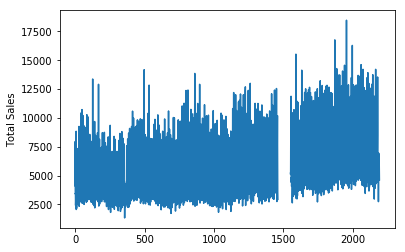

In [5]:
plt.plot(sales.Actual_total)
plt.ylabel("Total Sales")

There seems to be a sizeable amount of data missing (3 months) in the middle. We're just gonna drop it for EDA. The other option is to interpolate it because we have the amount of credit, just not cash. If credit and cash percent remains steady, we can just estimate what the gap might be

#### Credit Card Ratio - Dash example

Text(0, 0.5, 'Credit percentage total sales')

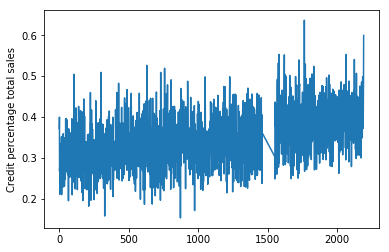

In [18]:
sales_dropped = sales.copy()
sales_dropped = sales_dropped.dropna(axis = 0, how='any')
sales_dropped["CreditRatio"] = sales_dropped["Credit"].astype(float)/(sales_dropped["Actual_total"])
plt.plot(sales_dropped["CreditRatio"])

plt.ylabel("Credit percentage total sales")

There's an upward trend in credit usage but it's not reliable metric for interpolation. Let's see what it looks like on an interactive chart and find out what values are missing

In [20]:
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='magehunter45', api_key='tD95tNEY6LEpbgyuXKZR')

#plt.scatter(x = sales_weekly_avg.index, y = sales_weekly_avg.Actual_total)

fig = {
    'data': [
        {
            'x': sales_dropped.Date,
            'y': sales_dropped.CreditRatio,
            'mode': 'markers',
            'marker': {'size': 2}
        }
    ],
    'layout': {
        'xaxis': {'title': 'Week of Year'},
        'yaxis': {'title': "Average Total Earnings"}    
    }
}
py.iplot(fig, filename='multiple-scatter')



High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~magehunter45/0 or inside your plot.ly account where it is named 'multiple-scatter'


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



12/31/14 to 04/01/15 is missing. Preceeding to drop values from data set. Also having an issue where there's overlaps for weekly resampling.

#### Column Indexing

Date.1 is a bad index name. I also want to create more columns by splitting into day of year, week of year, month of year, year

In [7]:
sales.columns = ['Date', 'Cash', 'Credit', 'Total', 'WeekDay', 'Actual_total']
sales.columns

Index(['Date', 'Cash', 'Credit', 'Total', 'WeekDay', 'Actual_total'], dtype='object')

It would probably be more efficient to convert this to a date-time index instead but I'm not being too picky right now

In [8]:
sales['Year'] = pd.DatetimeIndex(sales['Date']).year
sales['Month'] = pd.DatetimeIndex(sales['Date']).month
sales['Week'] = pd.DatetimeIndex(sales['Date']).week
sales['Day'] = pd.DatetimeIndex(sales['Date']).day

#sales['Year'], sales['Week'], sales['Month'], sales['Day']

In [9]:
hum = sales[sales.Year == 2012]
hum = hum[hum.Week == 1]
hum

,Date,Cash,Credit,Total,WeekDay,Actual_total,Year,Month,Week,Day
366,01/02/12,2250.0,1229.74,3479.74,Monday,3479.74,2012,1,1,2
367,01/03/12,2697.0,925.54,3622.54,Tuesday,3622.54,2012,1,1,3
368,01/04/12,2224.0,1097.7,3321.7,Wednesday,3321.70,2012,1,1,4
369,01/05/12,2387.0,686.05,3073.05,Thursday,3073.05,2012,1,1,5
370,01/06/12,2353.0,1452.58,3805.58,Friday,3805.58,2012,1,1,6
371,01/07/12,4050.0,2031.53,6081.53,Saturday,6081.53,2012,1,1,7
372,01/08/12,4961.0,2629.78,7590.78,Sunday,7590.78,2012,1,1,8
730,12/31/12,1197.0,1241.59,2438.59,Monday,2438.59,2012,12,1,31


Index for week is a bit off notice that the last day of the year is somehow week one. I'm gonna play a bit with the data first, but it is by no means the best at aggregating data or trends

<a id="Semi"></a>

## Semi-stationary Analysis  

This is a quick look into the data assuming there is no trend. This is mostly to practice a bit of pandas manipulation and confirm data in the time series analysis

In [10]:
#let's look at the data
sales.describe()

,Cash,Actual_total,Year,Month,Week,Day
count,2094.000000,2094.000000,2192.000000,2192.000000,2192.000000,2192.000000
mean,3303.672679,5180.061461,2013.500456,6.521898,26.596259,15.732664
std,1540.653272,2647.696951,1.708571,3.449773,15.068559,8.803378
min,854.000000,1334.570000,2011.000000,1.000000,1.000000,1.000000
25%,2224.000000,3242.940000,2012.000000,4.000000,14.000000,8.000000
50%,2811.000000,4365.835000,2013.500000,7.000000,27.000000,16.000000
75%,3793.500000,6150.612500,2015.000000,10.000000,40.000000,23.000000
max,9997.000000,18472.490000,2016.000000,12.000000,53.000000,31.000000


#### All data plotted

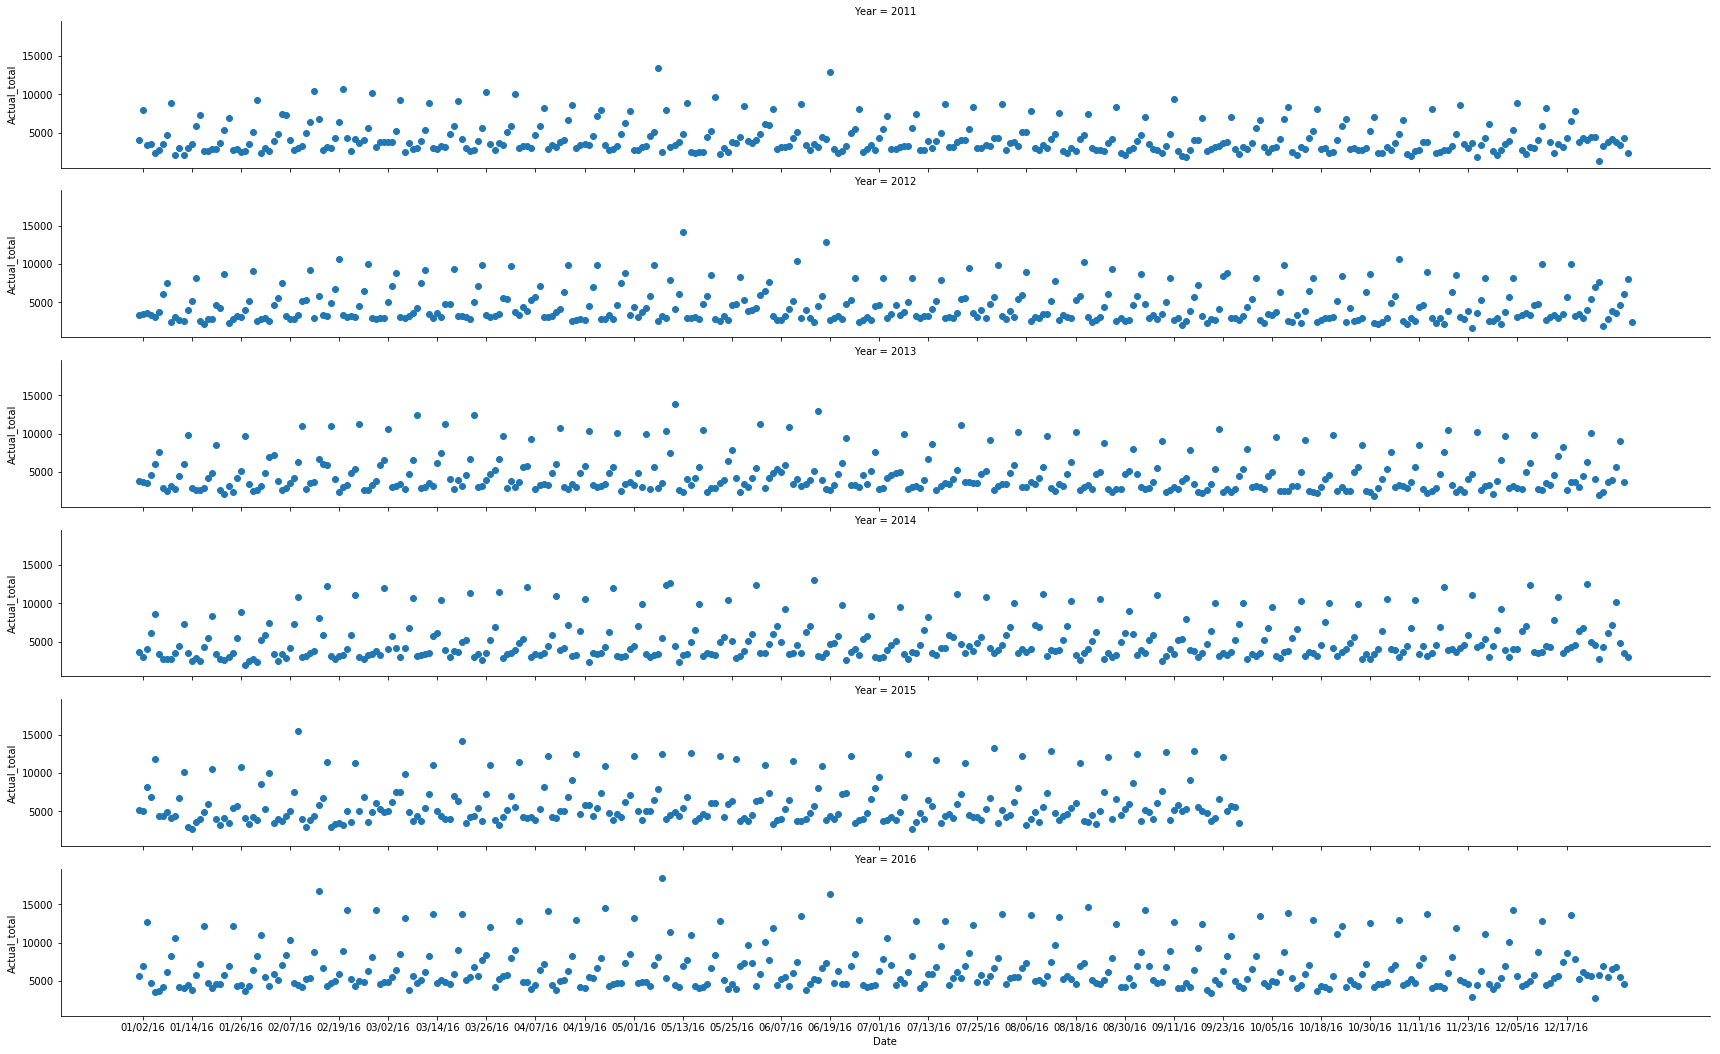

In [11]:
##FACET GRID
g = sns.FacetGrid(sales, row = "Year", aspect=8)
xticks= np.arange(1, 360, 12)
g = g.map_dataframe(plt.scatter, "Date","Actual_total").set(xticks= xticks)

#adding title to facet grid
plt.subplots_adjust(top=.8)

We can see some peaks at certain points in the data. Also note the missing 3 months from 12/31/14 to 04/01/15 

#### Weekly Seasonality of the year - because the view of each day is overwhelming. Plotly Example.

This chart is also going to be interactive so it's easier to view

In [12]:
sales_dropped = sales.copy().dropna()
sales_weekly_avg = sales_dropped.groupby("Week").agg("mean")

In [21]:
fig = {
    'data': [
        {
            'x': sales_weekly_avg.index, 
            'y': sales_weekly_avg.Actual_total, 
            'text': sales_weekly_avg.index, 
            'mode': 'markers'}
    ],
    'layout': {
        'xaxis': {'title': 'Week of Year'},
        'yaxis': {'title': "Average Total Earnings"}    
    }
}

# IPython notebook
py.iplot(fig, filename='week-sales')

#url = py.plot(fig, filename='pandas/multiple-scatter')

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



What's going on in week 53

In [20]:
sales_dropped[sales_dropped.Week == 53]

,Date,Cash,Credit,Total,WeekDay,Actual_total,Year,Month,Week,Day
1822,12/28/15,3042.0,2048.52,5090.52,Monday,5090.52,2015,12,53,28
1823,12/29/15,3705.0,1940.89,5645.89,Tuesday,5645.89,2015,12,53,29
1824,12/30/15,3489.0,2017.33,5506.33,Wednesday,5506.33,2015,12,53,30
1825,12/31/15,2261.0,1233.1,3494.1,Thursday,3494.10,2015,12,53,31
1826,01/01/16,3179.0,2531.06,5710.06,Friday,5710.06,2016,1,53,1
1827,01/02/16,3800.0,3207.17,7007.17,Saturday,7007.17,2016,1,53,2
1828,01/03/16,7179.0,5491.98,12670.98,Sunday,12670.98,2016,1,53,3


It looks like the sunday after new years was a surprise peak. Also note how bad sales are on new years day. Datetime package must have just jumped the gun, because it only has week 53 for one year.

Otherwise, week 7 and week 19 are massively higher than the rest which is easily explainable by Valentine's Day and Mother's day respectively. This will probably make more sense in the Time Series Analysis using prophet

But what about the variance of each week? Let's use a boxplot to check

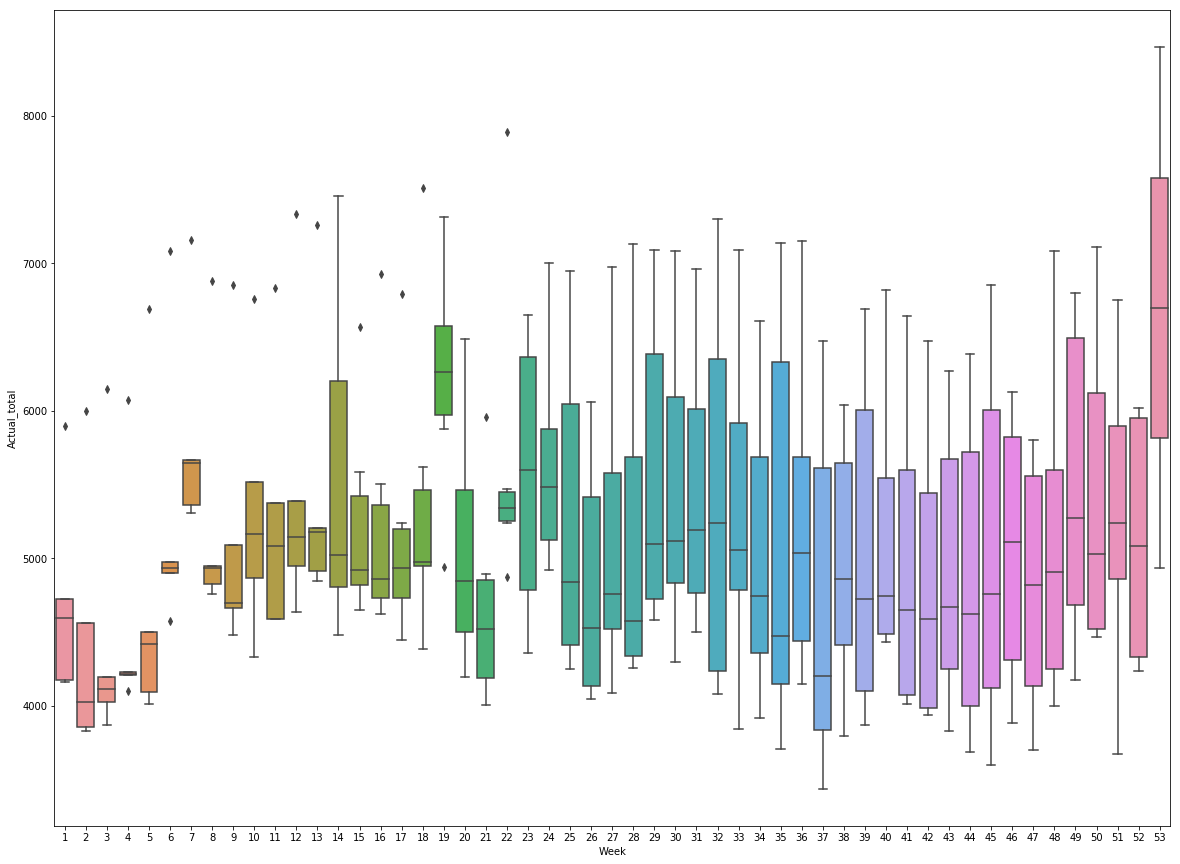

In [21]:
plt.figure(figsize=(20,15))
#get average week over years of sales
sales_weekly_year_avg = sales_dropped.groupby(['Week', 'Year']).agg("mean").reset_index()
sns.boxplot(x = sales_weekly_year_avg.Week, y = sales_weekly_year_avg.Actual_total, data = sales_weekly_year_avg)

The entire first 20 weeks seems to have weird outliers. I'm not sure why, but I'm assuming the time series analysis will be useful in teasing the data

After discussing with my brother though, it seems like those numbers are correct. 2015 was just a really good year and would have explained the massive boost. The gap between 2014 and 2016 is so large that the boxplot assumed that 2016 was an outlier.

The medians are all relatively similar and we see how week 53 is awkward because of the lack of data. What we can see from the chart is a lot of variability over the course of 6 years.

#### Monthly seasonality of the year - broader trends

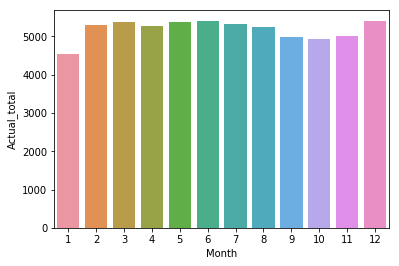

In [22]:
sales_month_avg = sales_dropped.groupby("Month").agg("mean")
sns.barplot(x = sales_month_avg.index, y = sales_month_avg.Actual_total)

Summer months tend to do the best as seen on the chart. September dip follows school starting. Month 1-3 is probably biased because it is missing the higher 2015 data.

#### Daily seasonality of the week - lets get deeper

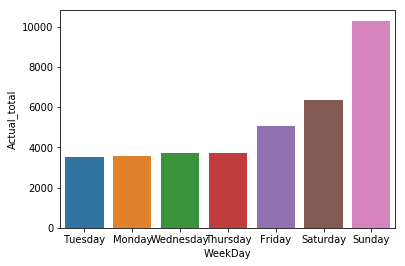

In [23]:
sales_dayofweek_avg = sales_dropped.groupby("WeekDay").agg("mean")
sales_dayofweek_avg = sales_dayofweek_avg.sort_values("Actual_total")
sns.barplot(x = sales_dayofweek_avg.index, y = sales_dayofweek_avg.Actual_total)

Sundays are extremely important. Not only is it all day dinner price, but it's assumed to be the most important day. The average here is 2.5 any other day during the week

<a id="Prophet"></a>

## Timeseries Analysis

By modeling sales as time series I can begin to decompose the data in order to find true outliers. I'm currently looking to remove the seasonality that can be explained by weekly and monthly changes. I'm keeping holidays in just in case there might be one that we're missing. 

#### Why fbprophet?

Prophet is an open source library by facebook for scaling time series forecasting. Their model is decomposed into trend, seasonality, and custom input holidays to the equation:

<i>y(t) = g(t) + s(t) + h(t) + εt.</i>

<b> g(t)</b>: piecewise linear or logistic growth curve for modelling non-periodic changes in time series

<b> s(t)</b>: periodic changes (e.g. weekly/yearly seasonality)

<b> h(t)</b>: effects of holidays (user provided) with irregular schedules

<b> ε_t</b>: error term accounts for any unusual changes not accommodated by the model

Note how time is the only regressor and that the model is essentially fitting to the curve and then generating values from the fit. This allows for quick model building and parameter tuning.

In [8]:
import pystan
from fbprophet import Prophet

<b>Tuneable Parameters</b>

<b>Carrying cap:</b> None, or at least not even close to meeting it. Currently utilizing linear model.

<b>Trend Change points:</b> Automatic, and only for the first 80% so doesn't overfit future predictions. Might change sparsity. 

<b>Holidays:</b> Mother's day, Christmas, Thanksgiving, Valentines

In [50]:
#make dataframe for fbprophet prediction. Using the full Data frame
#Even with gaps in data frame, fbprophet will fill in the blanks with
#predictions
fbdf = sales[['Date', 'Actual_total']]
fbdf.columns = ['ds','y']
fbdf.head()

,ds,y
0,01/01/11,4119.95
1,01/02/11,7954.69
2,01/03/11,3411.37
3,01/04/11,3468.88
4,01/05/11,2423.90


#### Holidays

In [10]:
#superbowl, christmas, thanksgiving, mother's day, valentine's day
valentines = pd.DataFrame({
  'holiday': 'valentine',
  'ds': pd.to_datetime(['2011-02-14', '2012-02-14','2013-02-14',
                        '2014-02-14', '2015-02-14','2016-02-14',
                        '2017-02-14'])
})
mother = pd.DataFrame({
  'holiday': 'mothers day',
  'ds': pd.to_datetime(['2011-05-08', '2012-05-13','2013-05-12',
                        '2014-05-11', '2015-05-10','2016-05-08',
                        '2017-05-14'])
})
mex_mother = pd.DataFrame({
  'holiday': 'mex mothers day',
  'ds': pd.to_datetime(['2011-05-10', '2012-05-10','2013-05-10',
                        '2014-05-10', '2015-05-10','2016-05-10',
                        '2017-05-10'])
})
father = pd.DataFrame({
  'holiday': 'fathers day',
  'ds': pd.to_datetime(['2011-06-19', '2012-06-17','2013-06-16',
                        '2014-06-15', '2015-06-21','2016-06-19',
                        '2017-06-18'])
})
thanksgiving = pd.DataFrame({
  'holiday': 'thanksgiving',
  'ds': pd.to_datetime(['2011-11-24', '2012-11-22','2013-11-28',
                        '2014-11-27', '2015-11-26','2016-11-24',
                        '2017-11-23']),
  'lower_window': 0,
  'upper_window': 1,
})
christmas = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2011-12-25', '2012-12-25','2013-12-25',
                        '2014-12-25', '2015-12-25','2016-12-25',
                        '2017-12-25']),
  'lower_window': -1,
  'upper_window': 0,
})
newyears = pd.DataFrame({
  'holiday': 'new years',
  'ds': pd.to_datetime(['2011-01-01', '2012-01-01','2013-01-01',
                        '2014-01-01', '2015-01-01','2016-01-01',
                        '2017-01-01']),
  'lower_window': -1,
  'upper_window': 0,
})
fifa_mexico = pd.DataFrame({
  'holiday': 'FIFA Mexico',
  'ds': pd.to_datetime(['2014-06-13', '2014-06-17','2014-06-23',
                        '2014-06-29'])
})
fifa_us = pd.DataFrame({
  'holiday': 'FIFA USA',
  'ds': pd.to_datetime(['2014-06-16', '2014-06-22','2014-06-26',
                        '2014-07-01'])
})
superbowl = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2017-02-05', '2016-02-07','2015-02-01',
                        '2014-02-02', '2013-02-03','2012-02-05',
                        '2011-02-06'])
})
holidays = pd.concat((valentines, mother, mex_mother, father, thanksgiving, christmas, newyears, fifa_mexico, fifa_us, superbowl))

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:66: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



#### Developing the model

Now I'm going to create the prophet object and fit the trend

In [11]:
m = Prophet(holidays = holidays)
m.fit(fbdf)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


This will extend the dataframe by 365 periods (days in this dataset) to make prediction later

In [12]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
2552,2017-12-27
2553,2017-12-28
2554,2017-12-29
2555,2017-12-30
2556,2017-12-31


Now, taking the fit, I'm doing to predict future values and get a range for the values I'm predicting

In [13]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2552,2017-12-27,6509.780198,5535.058164,7502.964498
2553,2017-12-28,6477.364481,5350.409135,7439.037799
2554,2017-12-29,7780.230291,6760.530937,8806.408841
2555,2017-12-30,9020.569096,7990.050581,10047.964097
2556,2017-12-31,12802.951606,11682.120512,13811.217177


Now lets see the effects of different holidays 

In [14]:
holiday_effects = forecast[(forecast['valentine'] + forecast['mothers day'] + forecast['mex mothers day'] + forecast['christmas'] + forecast['fathers day'] + forecast['thanksgiving'] + forecast['new years']).abs() > 0][
    ['ds', 'valentine', 'mothers day', 'mex mothers day', 'christmas', 'fathers day', 'thanksgiving', 'new years']]
holiday_effects[-10:]

,ds,valentine,mothers day,mex mothers day,christmas,fathers day,thanksgiving,new years
2191,2016-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2157.925806
2192,2017-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1450.153480
2236,2017-02-14,3419.704453,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2321,2017-05-10,0.000000,0.000000,4997.045349,0.000000,0.000000,0.000000,0.000000
2325,2017-05-14,0.000000,3758.774636,0.000000,0.000000,0.000000,0.000000,0.000000
2360,2017-06-18,0.000000,0.000000,0.000000,0.000000,3430.938308,0.000000,0.000000
2518,2017-11-23,0.000000,0.000000,0.000000,0.000000,0.000000,-1167.123728,0.000000
2519,2017-11-24,0.000000,0.000000,0.000000,0.000000,0.000000,-918.325119,0.000000
2549,2017-12-24,0.000000,0.000000,0.000000,-2761.100424,0.000000,0.000000,0.000000
2550,2017-12-25,0.000000,0.000000,0.000000,-2889.932120,0.000000,0.000000,0.000000


And the effects of different sporting events

In [15]:
sports_effects = forecast[(forecast['FIFA Mexico'] + forecast['FIFA USA'] + forecast['superbowl']).abs() > 0][['ds', 'FIFA Mexico', 'FIFA USA', 'superbowl']]
sports_effects

,ds,FIFA Mexico,FIFA USA,superbowl
36,2011-02-06,0.000000,0.000000,-2154.241009
400,2012-02-05,0.000000,0.000000,-2154.241009
764,2013-02-03,0.000000,0.000000,-2154.241009
1128,2014-02-02,0.000000,0.000000,-2154.241009
1259,2014-06-13,-411.032291,0.000000,0.000000
1262,2014-06-16,0.000000,-280.051784,0.000000
1263,2014-06-17,-411.032291,0.000000,0.000000
1268,2014-06-22,0.000000,-280.051784,0.000000
1269,2014-06-23,-411.032291,0.000000,0.000000
1272,2014-06-26,0.000000,-280.051784,0.000000


All of these holidays and events now have a measureable impact. Surprisingly, the world cup has a negligible effect on business. The superbowl has a much stronger effect than originally thought.

Prophet will also give predictive values for the gap value as shown in the plot below

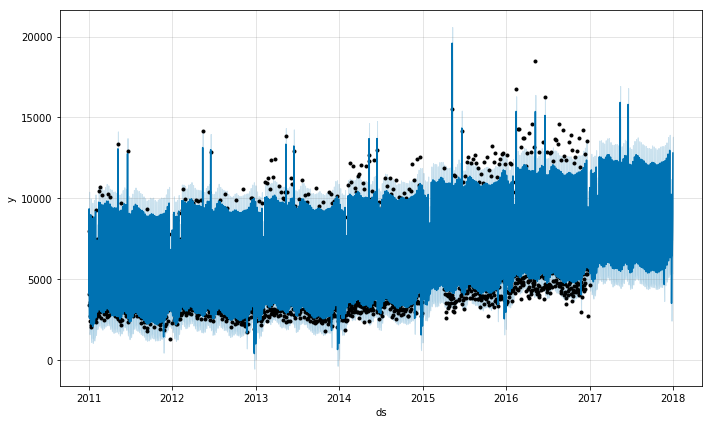

In [16]:
fig1 = m.plot(forecast)

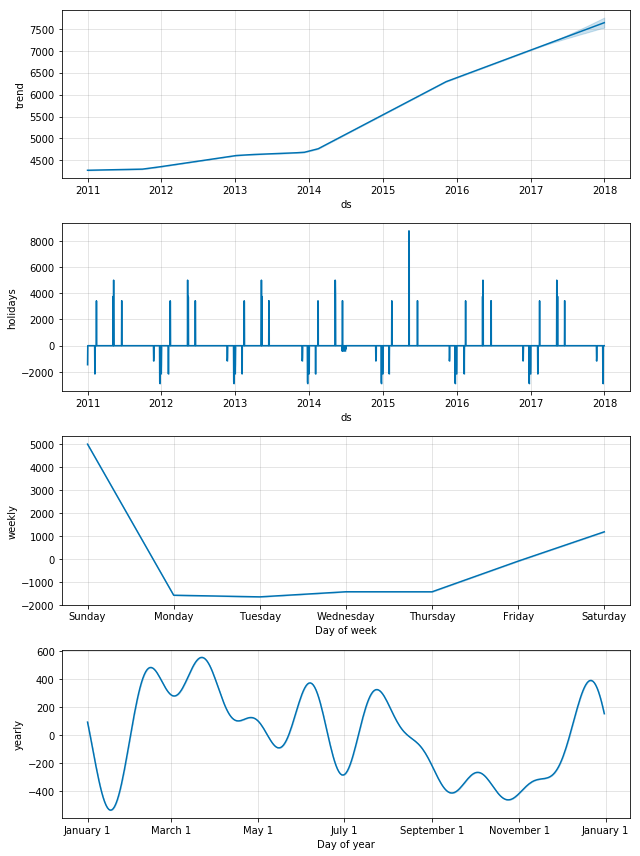

In [17]:
fig2 = m.plot_components(forecast)

Gonna check to see that this prediction makes sense using diagnostics. Starting from 2 years in, it will attempt to cross validate every 180 days for a window of one year.

In [18]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2013-01-16 00:00:00 and 2016-01-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-01-17,3031.133059,2290.741526,3850.969272,2919.75,2013-01-16
1,2013-01-18,4217.699269,3353.445467,5017.176356,4226.48,2013-01-16
2,2013-01-19,5530.830184,4673.357168,6374.676782,4856.27,2013-01-16
3,2013-01-20,8494.781704,7762.271299,9276.413185,8575.50,2013-01-16
4,2013-01-21,2998.981629,2206.357508,3763.120633,2701.54,2013-01-16


In [19]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
1121,40 days,554660.201086,744.755128,564.200653,0.115475,0.761702
2031,40 days,562867.178412,750.244746,569.655253,0.116734,0.757447
403,40 days,565034.576742,751.687819,572.171919,0.117218,0.757447
767,40 days,566548.849686,752.694393,573.893034,0.117734,0.757447
1670,40 days,567140.587687,753.087371,575.065509,0.117926,0.757447


An RMSE of 800 is pretty large, but understandably the best forecasting can do sometimes. 

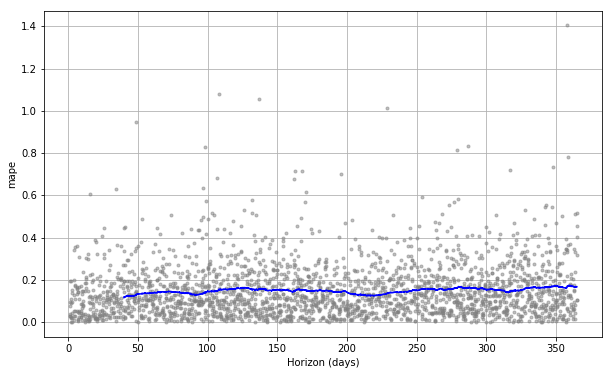

In [20]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [21]:
# calculate outliers based on number of deviations away from yhat. 
#(is yhat_upper - yhat one stdev?)
deviation_multiplier = 3
upper_outliers = df_cv[(df_cv["yhat_upper"] - df_cv["yhat"]) * deviation_multiplier + df_cv["yhat"] < df_cv["y"]]
lower_outliers = df_cv[(df_cv["yhat_lower"] - df_cv["yhat"]) * deviation_multiplier + df_cv["yhat"] > df_cv["y"]]
upper_outliers.shape, lower_outliers.shape

((32, 6), (8, 6))

## These are the outliers to check out first. Then reduce deviation_multiplier to 2.

In [22]:
upper_outliers

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
52,2013-03-10,9288.902153,8501.863063,10047.909398,12381.01,2013-01-16
66,2013-03-24,9410.696286,8621.566847,10212.965176,12422.56,2013-01-16
637,2014-04-16,3903.529905,3079.599239,4775.541431,7114.60,2013-07-15
822,2014-04-16,3676.636544,2772.516850,4458.877025,7114.60,2014-01-11
868,2014-06-01,9470.572575,8622.833797,10332.863272,12392.10,2014-01-11
960,2014-09-01,2947.558240,2126.200415,3838.865828,5957.67,2014-01-11
1036,2014-11-16,8820.817316,7934.433617,9724.709565,12098.17,2014-01-11
1057,2014-12-07,9090.924978,8229.400442,9911.250245,12417.25,2014-01-11
1071,2014-12-21,9506.860567,8665.901102,10322.680304,12553.69,2014-01-11
1075,2014-12-25,1155.377658,241.401295,2044.161094,4353.12,2014-01-11


In [23]:
lower_outliers

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
107,2013-05-04,6227.817785,5402.158274,7003.731043,2997.99,2013-01-16
591,2014-03-01,6465.562788,5550.763112,7335.109503,3212.49,2013-07-15
776,2014-03-01,6246.952226,5408.818729,7085.184288,3212.49,2014-01-11
1295,2015-05-10,19489.495374,18572.934571,20431.835766,15530.50,2014-07-10
1394,2015-05-10,20729.115042,19873.616366,21605.005441,15530.50,2015-01-06
1407,2015-05-23,7460.606160,6501.419422,8316.784374,3625.27,2015-01-06
2347,2016-12-24,6600.184905,5657.085145,7540.989799,2745.47,2016-01-01
2348,2016-12-25,10292.316730,9347.033397,11273.680558,5772.94,2016-01-01


It seems that having both US and Mexican mother's days link up equates to an additive regression that is essentially the capacity for the restaurant. The day was apparently booked by a line from beginning to end.

No notable dates are recurring year after year, so I'm going to wipe out the values.

#### Tuning

Let's see what happens when we adjust the parameters such as the prediction interval width and the changepoints.

In [104]:
max(fbdf['y'])

18472.49

In [95]:
m = Prophet(interval_width = .95, changepoint_prior_scale=0.7, holidays = holidays)#, interval.width = 0.95, mcmc.samples = 300) # default is .05. 
#Increase trend flexibility if underfitting. Will also increase uncertainty
#Can also adjust confidence level, normally .80
#mcmc replaces map estimation with mcmc sampling to get full bayesian sampling on seasonality
m.fit(fbdf)
forecast = m.predict(fbdf)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2013-01-16 00:00:00 and 2016-01-01 00:00:00


,horizon,mse,rmse,mae,mape,coverage
1121,40 days,548347.427667,740.504846,555.225954,0.113600,0.902128
2031,40 days,555577.150585,745.370479,560.094536,0.114692,0.902128
403,40 days,556932.518836,746.279116,561.516902,0.114943,0.902128
767,40 days,558280.929758,747.181992,563.261821,0.115469,0.902128
1670,40 days,558391.908382,747.256253,563.472722,0.115455,0.902128


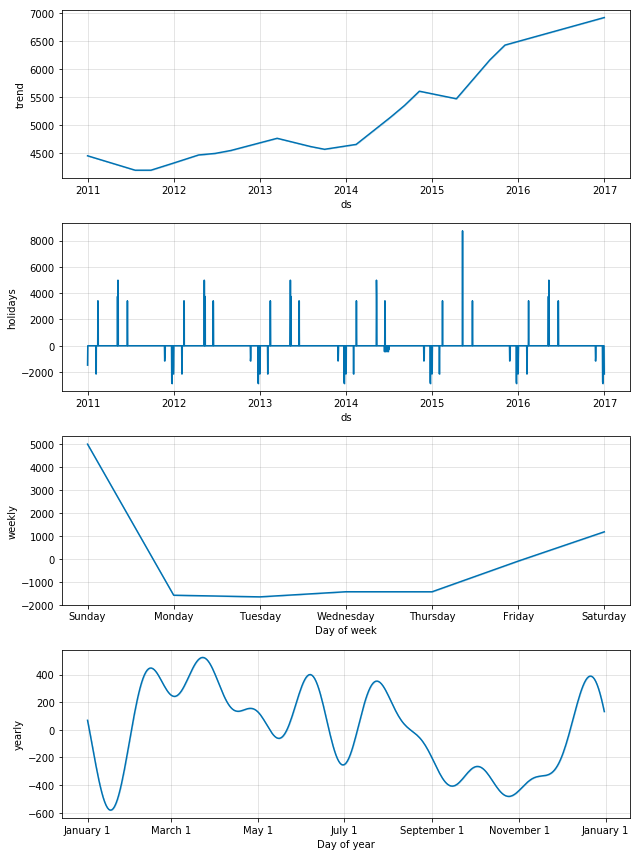

In [96]:
fig1 = m.plot_components(forecast)

The graph seems much more unstable, especially the trend. Will likely return to prior interval_width

## Weather Regression

I used a Beautiful Soup earlier to scrape some data on the weather near the restaurant between 2011 and 2017 since no easy, free api was available. I'm going to port it over and add it as a regressive variable to see the effect that the rain might have had on sales, because it rarely happens in San Diego.

First I'm gonna see if I need to clean the data up a little

In [111]:
fbdf_with_weather = fbdf.copy()
weather = pd.read_csv("WeatherData")
weather = weather.drop("Unnamed: 0", axis = 1)

fbdf_with_weather['ds'] = pd.to_datetime(fbdf_with_weather['ds'])
weather['Date'] = pd.to_datetime(weather['Date'])

In [112]:
compared = pd.merge(fbdf_with_weather, weather, left_on='ds', 
                    right_on='Date', how='outer')
compared.loc[compared.Date.isnull() == True]

,ds,y,Date,MaxTemp,MinTemp,Precipitation
424,2012-02-29,2916.12,NaT,NaN,NaN,NaN
1885,2016-02-29,4549.76,NaT,NaN,NaN,NaN


No weather data for leap year. Gonna wipe those two dates for calculation

In [113]:
fbdf_with_weather.drop(labels = [424, 1885], axis = 0, inplace = True)
fbdf_with_weather = fbdf_with_weather.reset_index(drop=True)

In [114]:
fbdf_with_weather.tail()

,ds,y
2185,2016-12-27,5553.29
2186,2016-12-28,6604.82
2187,2016-12-29,6813.19
2188,2016-12-30,5577.16
2189,2016-12-31,4636.06


Now I'm gonna include inches of rain as a regressor variable when calculating sales to determine it's effect

In [117]:
fbdf_with_weather['Precipitation'] = weather.Precipitation
m = Prophet(holidays = holidays)#, interval.width = 0.95, mcmc.samples = 300) # default is .05. 
m.add_regressor('Precipitation')
m.fit(fbdf_with_weather)

forecast = m.predict(fbdf_with_weather)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2013-01-16 00:00:00 and 2016-01-01 00:00:00


,horizon,mse,rmse,mae,mape,coverage
1670,40 days,560740.103301,748.825816,562.759219,0.114363,0.770213
2030,40 days,569111.303276,754.394660,568.219995,0.115617,0.765957
403,40 days,571323.825527,755.859660,570.739409,0.116101,0.765957
1121,40 days,572165.222133,756.416038,571.883358,0.116597,0.765957
39,40 days,579044.245526,760.949568,576.848809,0.118484,0.761702


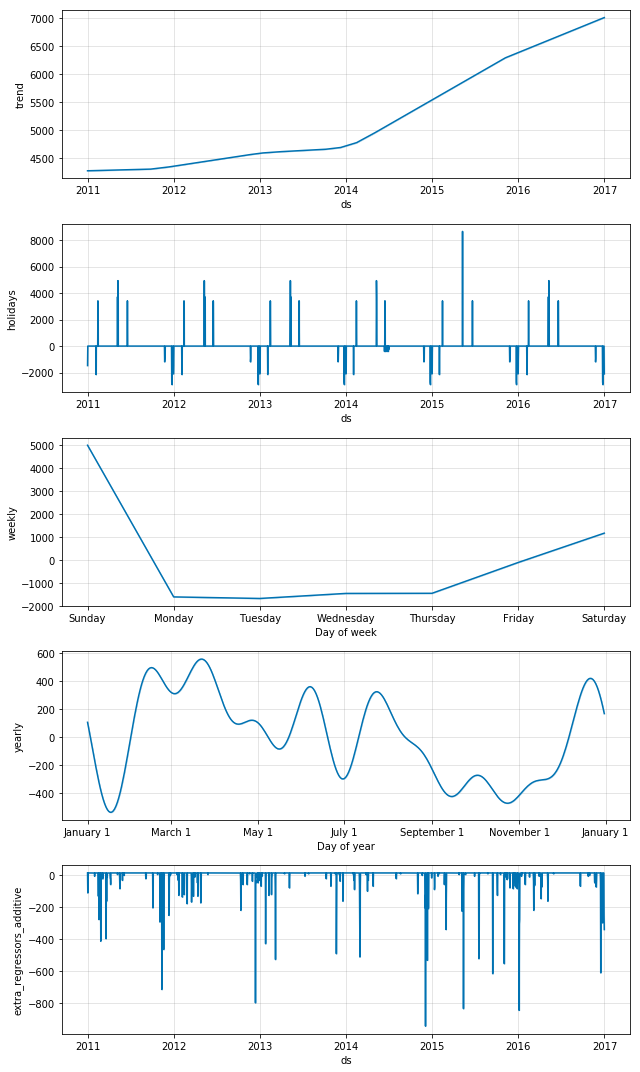

In [118]:
fig3 = m.plot_components(forecast)

In [121]:
min(forecast['extra_regressors_additive'])/max(weather['Precipitation'])

-513.0927527342222

## Conclusions

We can predict sales with a reasonable 11% mean absolute percentage error

Superbowl sunday has a much more sizeable effect than originally thought. One way to gain customers back is to put the game on a tv and offer superbowl-like food for the day. At a measureable cost of 2000$\$$ + a year, a new tv would only be a one-time cost of 500$\$$ and food would not be much more expensive.

By exploring the outliers, I was also able to find that Mexican Mother's day has an even larger effect than mother's day in the US. The restaurant is in a predominatly Hispanic area, thus would do well to meet the needs of the holiday/change to holiday pricing.

Credit use is increasing over time, but not much else can be predicted off of it.

The each inch of rain essentially cuts 500$\$$ off sales